# Data Preparation 
This second notebook in the Conversion Rate Prediction project picks up where the Data Profiling notebook breaks. Data Profiling illuminated broad data quality aspects of the Criteo Sponsored Search Conversion Log Dataset. This step down the data pipeline is about rendering the dataset which will be used for exploratory data analysis and further downstream modeling and prediction of conversion rates in delayed feedback settings.

Concretely, the following data preparation steps are undertaken:
1. Normalization of numeric data using Robust Z-Score Normalization.
2. Transformation of data to comport with statistical inference assumptions around linearity, normality, uniform variance and other assumptions.
3. Detection, analysis and treatment of outliers in the dataset.
4. Dimensionality reduction via Principle Components Analysis

Data are being provided courtesy of Criteo Labs and are summarized here and in each notebook for referencability.



## Internal Module Overview

| Module    | Class           | Description                                                                                 |
|-----------|-----------------|---------------------------------------------------------------------------------------------|
| acquire   | Acquire         | Obtains the Criteo Criteo Sponsored Search Conversion Log Dataset from   its source website |
| datastore       | DataStore             | Data access object encapsulates i/o of data files within the data   pipeline                |
| profile   | DataProfiler    | Data quality assessment                                                                     |
| transform | Transformer     | Performs and provides visualization of data transformations                                 |
| visualize | Visual          | Data visualization                                                                          |
| outliers  | OutlierDetector | Detects outliers in numeric and categorical data.                                           |

## 1. Setup
Imports, parameters and modules required for the data preparation notebook.
### 1.1. Module Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
pd.options.mode.chained_assignment = None  # default='warn'
import warnings 
warnings.filterwarnings("ignore",category=RuntimeWarning)
#-----------------------------------------

from cvr.data.outliers import OutlierDetector
from cvr.visuals.visualize import Visual
from cvr.data.datastore import DataStore
from cvr.data.prep import DataPrep
from cvr.visuals.transform import Transformer
from cvr.data import numeric_columns, categorical_columns


### 1.2. Parameters
The following parameters control behavior throughout data preparation effort.

In [2]:
sample_size = 0.01        # Proportion of data to sample
random_state = 55         # Pseudo random number generator seed
version = 'dev'           # Version of data to use, either 'prod' for production or full set, or 'dev' development set.
input_stage = 'staged'    # The stage of the input data in the data processing pipeline
output_stage = 'prepped'  # The stage of the output data in the data processing pipeline

### 1.2. Compile Modules
Modules required for data access, visualization, data transformation, outlier detection, and data preparation

In [3]:
datastore_staged = DataStore(stage=input_stage, version=version)                # Input Data Access Object
datastore_prepped = DataStore(stage=output_stage, version=version)              # Output Data Access Object

visual = Visual(palette='vlag')                                     # Data Visualization Object

transformer = Transformer(visual)                                   # Transformer and evaluation object

outlier_detector = OutlierDetector(criterion='vote',                # Outlier Detection Object
                                   random_state=random_state)    


data = DataPrep(datastore_in=datastore_staged,                                  # Data Processor Object
                  datastore_out=datastore_prepped,
                  visual=visual,
                  transformer = transformer,
                  outlier_detector=outlier_detector, 
                  version=version)   

In [4]:
%reload_ext watermark
%watermark -v -m -p pandas,numpy,sklearn,tensorflow

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.30.1

pandas    : 1.3.5
numpy     : 1.20.3
sklearn   : 1.0.2
tensorflow: 2.0.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 44 Stepping 2, GenuineIntel
CPU cores   : 24
Architecture: 64bit



## 2. Normalization
All numerical features and targets are normalized using the Robust Z-Score Normalization defined as:

$$x_{\text{normalized}} = \frac{x-\text{median(x)}}{IQR(x)}$$
where IQR(x) is the interquartile range of the variable. This ensures that the influence of any potential outliers on the normalization is minimized. The normalize method on the data object will apply this normalization to all numeric columns. 

Before we normalize, let's examine the descriptive statistics for the numeric variables.

In [5]:
data.describe(columns=numeric_columns)



                 Criteo Sponsored Search Conversion Log Dataset                 
                             Descriptive Statistics                             
                 ______________________________________________                 
                         count              mean               std          min            25%             50%               75%              max
---------------------  -------  ----------------  ----------------  -----------  -------------  --------------  ----------------  ---------------
sales_amount             17654     113.934           226.259        0             23.4289         52               121.761         7486.13
conversion_time_delay    17591  321675            589318            9            659            3476            351417                2.57944e+06
click_ts                159956       1.60054e+09       2.27065e+06  1.59644e+09    1.5986e+09      1.60066e+09       1.60251e+09      1.6043e+09
sale_ts                 159956   

The breadth and depth of variation among these numeric data elements are significant. Let's normalize and take another look.

In [6]:
data.normalize()
data.describe(columns=numeric_columns)



                 Criteo Sponsored Search Conversion Log Dataset                 
                             Descriptive Statistics                             
                 ______________________________________________                 
                         count        mean       std          min          25%    50%       75%         max
---------------------  -------  ----------  --------  -----------  -----------  -----  --------  ----------
sales_amount             17654   0.629847   2.30096   -0.528819    -0.290557        0  0.709443   75.6021
conversion_time_delay    17591   0.907175   1.68013   -0.00988431  -0.00803118      0  0.991969    7.34399
click_ts                159956  -0.0307595  0.581674  -1.08215     -0.527964        0  0.472036    0.931951
sale_ts                 159956  -0.0335068  0.584975  -1.09673     -0.528218        0  0.471782    1.20974
n_clicks_1week           92503   1.75428    6.65565   -0.188119    -0.163366        0  0.836634  117.743
produc

We have all numeric variables now centered and normalized on their median values. 

Next, we move on to transformation.

## 3. Transformation
Here, we will perform data transformations on numeric variables to address the right skew distributions observed during the data profiling stage. Concretely, the financial and count data below are prime candidates for transformation.  
1. sales_amount,
2. n_clicks_1week, and 
3. product_price

These right-skewed data are the focus as we attempt to bring about distributions that meet linearity, normality and heteroskedasticity assumptions frequentist statistical inference.

We will also evaluate whether transformation should be applied to time or temporal variables such as click_ts, sale_ts, conversion_delay.

### 3.0 Sales Amount
Let's start with 'sales_amount'. Without transformation, this variable exhibits strong positive skew.

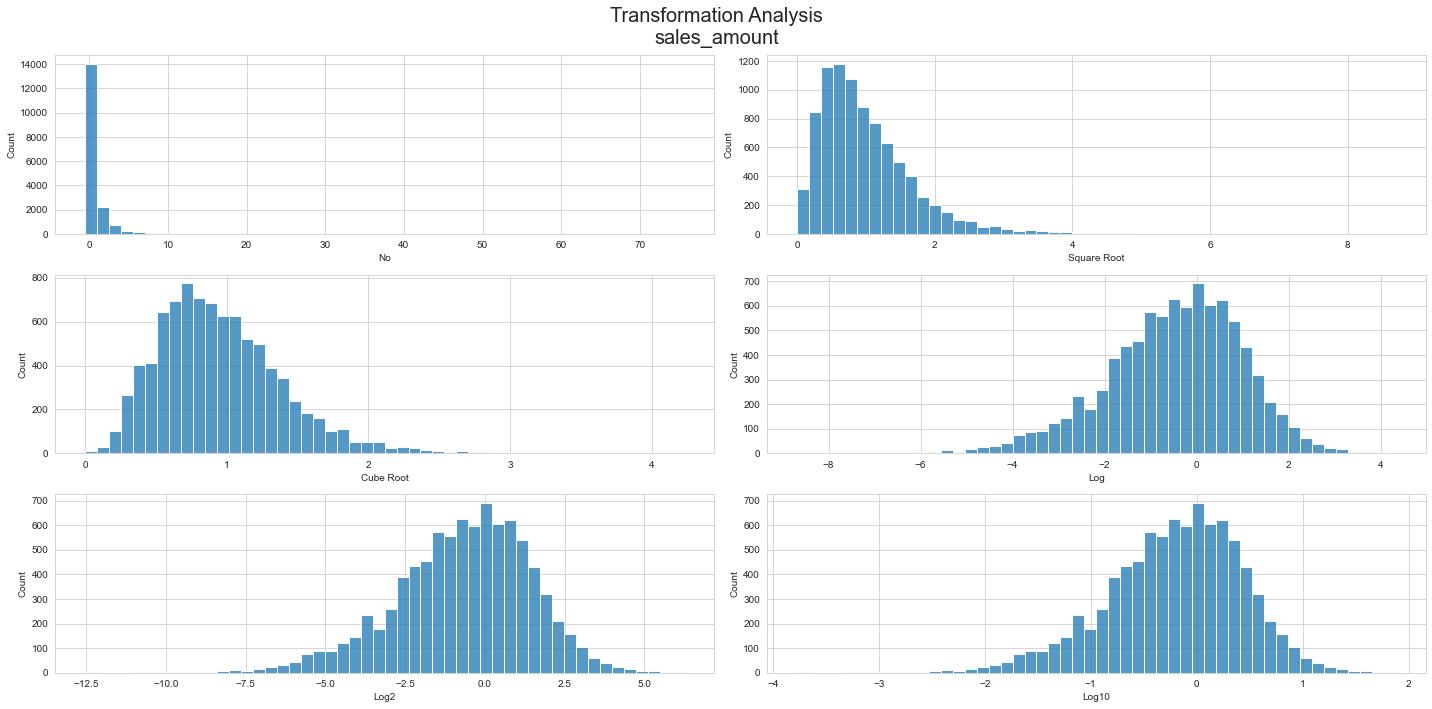

In [7]:
results = data.explore_transformations(columns=['sales_amount'])

The Log10 transformation appears to make since for this data. Let's apply it.

In [8]:
data.apply_transformation(columns=['sales_amount'], transformation='Log10')

### 3.1 Clicks 1 Week
Moving to the count data, we have n_clicks_1week which shows a similar long right tail.

In [9]:
results = data.explore_transformations(columns=['n_clicks_1week'])

The distribution opens up nicely under the log transformation and the test reveals support for rejecting the null. Let's apply it.

In [10]:
data.apply_transformation(columns=['n_clicks_1week'], transformation='Log')

### 3.2 Product Price
Next, we examine product price, another long-tailed distribution.

In [11]:
results = data.explore_transformations(columns=['product_price'])

Numerical stability issues aside, the Log10 stands out as a reasonable choice from a graphic assessment.

In [12]:
data.apply_transformation(columns=['product_price'], transformation='Log10')

### 3.3 Conversion Time Delay
Next, we move on to the temporal data variables. As shown below, conversion time delay without transformation reveals a long right-tailed distribution found in financial and count data.

In [13]:
results = data.explore_transformations(columns=['conversion_time_delay'])

The cuberoot transformation, a fairly strong transformation has the benefit of being applicable in zero value cases. The transformation brings out a multimodal, layered presentation suggesting some yet to be discovered, underlying structure. Let's apply it.

In [14]:
data.apply_transformation(columns=['conversion_time_delay'], transformation='Cube Root')

Click and sale timestamps are strongly correlated by definition. Let's examine their distributions under transformation.
### 3.4 Click TS
Click timestamp without transformation has the characteristic trend and seasonality lurking beneath the slightly increasing almost uniform distribution.

In [15]:
results = data.explore_transformations(columns=['click_ts'])


### 3.5 Sale Ts
Before closing out the section on transformations, let's see if there are any surprises in the sales timestamp distribution.

In [16]:
results = data.explore_transformations(columns=['sale_ts'])

To no one's surpise, these time stamps exhibit typical time series distribution tendencies. We'll leave these variables as they are ...for now.

### 3.6 Transformation Summary
We've examined the distributions for the numerical variables. In most cases, the data have exhibited inference friendly-er properties under transformation. Next, outlier detection.

## 4. Outlier Detection
Unsupervised voting-based outlier detection ensembles were applied to numeric and categorical data. For numeric data, three anomaly detection algorithms were used: Local Outlier Factor (LOF), Isolation Forest (IFS), and a Robust Covariance Matrix Estimation based method. For categorical data Attribute Value Frequency (AVF) Weighted Attribute Value Frequency (WAVF) and the Square of the Compliment Frequency (SCF) algorithms were used. Outlier labels from the ensemble were computed and majority vote (averaging) determined final final outlier labeling. 
### 4.0. Numeric Data Outlier Detection
Local Outlier Factor (LOF)
